<a href="https://colab.research.google.com/github/vijaygwu/causal/blob/main/Cluster_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code demonstrates a simulation study on the performance of statistical inference under clustered data structures.
### Imports and Setup
- Standard data science libraries (numpy, pandas, statsmodels, plotnine)
- SSL configuration for secure data downloads
- A function to read Stata files from an online repository

### Data Generation Function: `gen_cluster()`
This function creates synthetic data with a clustered structure:

1. **Correlation Structure**:
   - Creates two covariance matrices: `Sigma_i` for individual-level variation and `Sigma_cl` for cluster-level variation
   - The parameter `rho` controls how much of the total variance is at the cluster level vs. individual level

2. **Data Creation**:
   - Generates random values at both individual and cluster levels
   - Creates clusters (groups) of observations
   - Combines individual and cluster-level components to create:
     - A predictor variable `x`
     - An error term
   - Generates the outcome `y` using a linear model: y = param[0] + param[1]*x + error

### Single Simulation Function: `cluster_sim()`
Runs one iteration of the simulation:

1. Generates clustered data using `gen_cluster()`
2. Fits a linear regression model (OLS) with or without cluster-robust standard errors
3. Extracts the coefficient for x (using `.iloc[1]` for pandas Series)
4. Calculates standard errors and a 95% confidence interval
5. Returns the estimates and confidence interval bounds

### Simulation Runner: `run_cluster_sim()`
Orchestrates multiple simulations:

1. Runs `cluster_sim()` 1,000 times by default
2. Collects all results in a dataframe
3. Adds a column indicating whether each confidence interval contains the true parameter value
4. Returns the compiled results

### Execution and Analysis
1. Runs 1,000 simulations with these parameters:
   - `sim_params = [.4, 0]`: The true intercept is 0.4 and the true slope is 0
   - `rho = 0`: No clustering in the error structure
   - `cluster_robust = False`: Using regular (non-robust) standard errors

2. Visualization:
   - First plot: Histogram of all estimated coefficients
   - Second plot: Confidence intervals for 100 randomly selected simulations, color-coded by whether they contain the true value

3. Type I Error Rate Calculation:
   - Calculates the percentage of confidence intervals that do NOT contain the true parameter
   - This should be approximately 5% if the confidence intervals are correctly calibrated at 95%

### Key Statistical Concepts Demonstrated
1. **Sampling Distribution**: The histogram shows the distribution of coefficient estimates across repeated samples
2. **Confidence Interval Coverage**: The simulation checks how often 95% confidence intervals actually contain the true parameter
3. **Type I Error Rate**: The proportion of simulations where the null hypothesis (β=0) is incorrectly rejected

The final output should show a Type I error rate close to 5% (0.05) since you're using 95% confidence intervals. This confirms that the statistical inference procedure is correctly calibrated when there's no clustering in the data and you're using standard OLS estimation.

Type I error rate: 0.0430
Displaying histogram of coefficient estimates...


/usr/local/lib/python3.11/dist-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 24'. Pick better value with 'binwidth'.


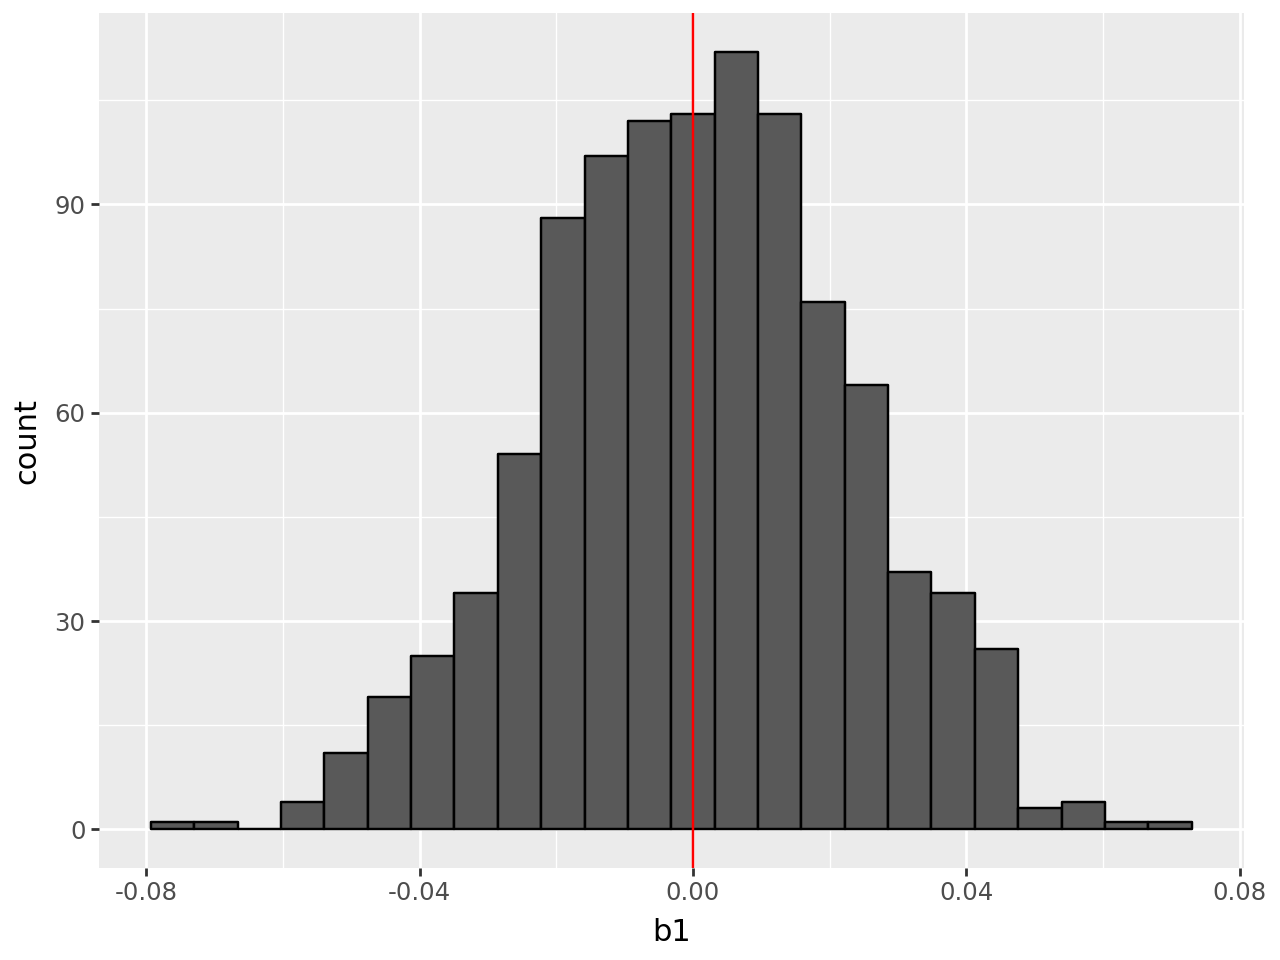

Displaying confidence intervals...


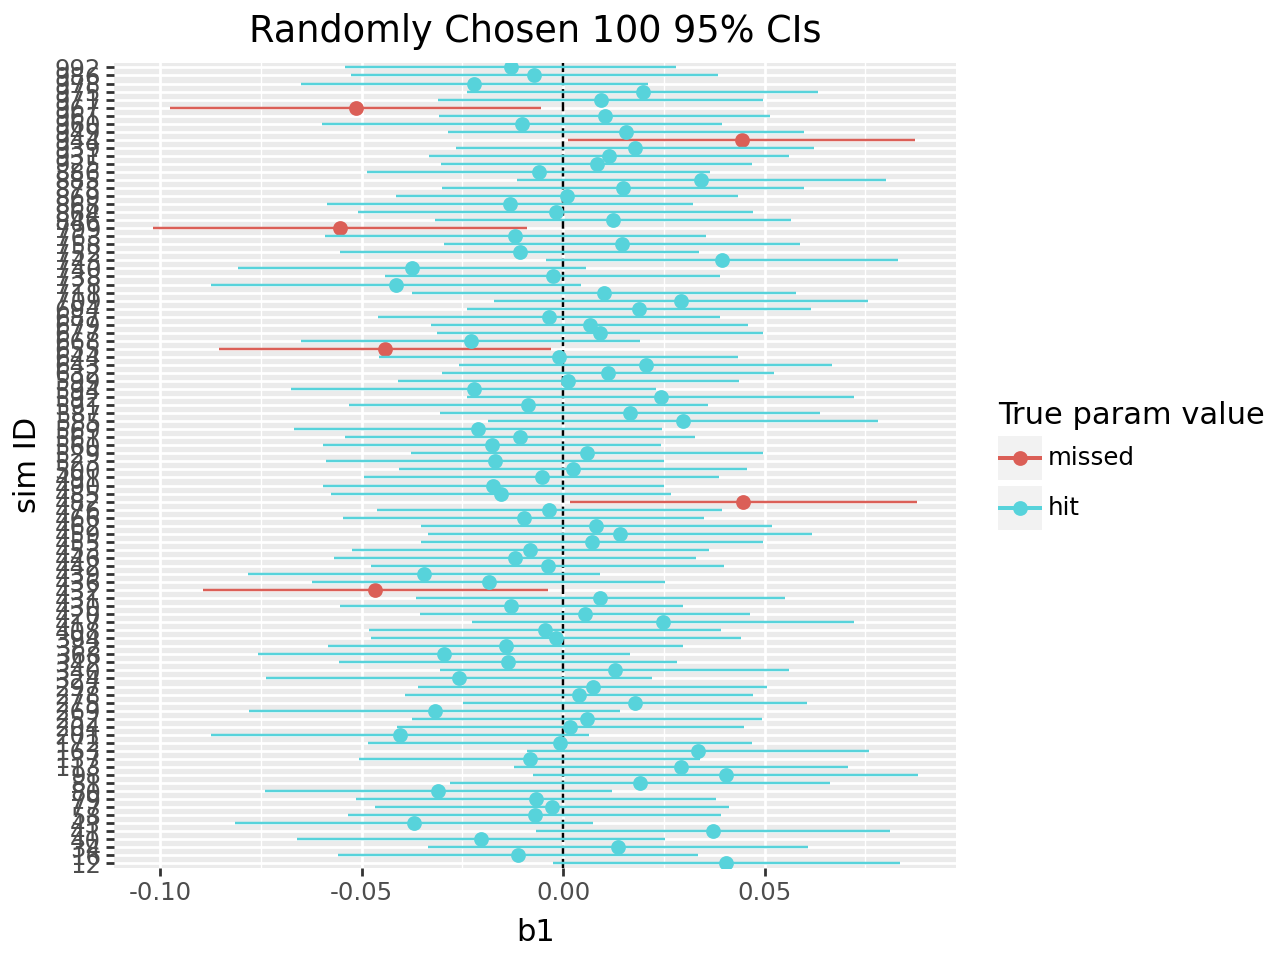

In [4]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from itertools import combinations
import plotnine as p

# read data
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

def read_data(file):
    return pd.read_stata("https://github.com/scunning1975/mixtape/raw/master/" + file)

def gen_cluster(param = (.1, .5), n = 1000, n_cluster = 50, rho = .5):
    # Function to generate clustered data
    # individual level
    Sigma_i = np.array((1, 0, 0, 1 - rho)).reshape(2,2)
    values_i = np.random.multivariate_normal(np.zeros(2), Sigma_i, size = n)

    # cluster level
    cluster_name = np.repeat(np.arange(1, n_cluster+1), repeats = n / n_cluster)
    Sigma_cl = np.array((1, 0, 0, rho)).reshape(2,2)
    values_cl = np.random.multivariate_normal(np.zeros(2), Sigma_cl, size = n_cluster)

    # predictor var consists of individual- and cluster-level components
    x = values_i[:, 0] + np.repeat(values_cl[:, 0], repeats = n / n_cluster)

    # error consists of individual- and cluster-level components
    error = values_i[:, 1] + np.repeat(values_cl[:, 1], repeats = n / n_cluster)

    # data generating process
    y = param[0] + param[1]*x + error

    df = pd.DataFrame({'x':x, 'y':y, 'cluster': cluster_name})
    return df

def cluster_sim(param = (.1, .5), n = 1000, n_cluster = 50, rho = .5, cluster_robust = False):
    df = gen_cluster(param = param, n = n, n_cluster = n_cluster, rho = rho)

    if not cluster_robust:
        fit = sm.OLS.from_formula('y ~ x', data = df).fit()
    else: # cluster-robust SE
        fit = sm.OLS.from_formula('y ~ x', data = df).fit(cov_type='cluster', cov_kwds={'groups': df['cluster']})

    # Fixed line using .iloc for pandas Series
    b1 = fit.params.iloc[1]  # Using .iloc for positional indexing with pandas Series
    Sigma = fit.cov_params()

    # For NumPy arrays, keep using direct indexing
    se = np.sqrt(np.diag(Sigma)[1])  # np.diag returns a NumPy array, not a pandas Series
    ci95 = se*1.96
    b1_ci95 = (b1-ci95, b1+ci95)
    return (b1, se, *b1_ci95)

def run_cluster_sim(n_sims = 1000, param = (.1, .5), n = 1000,
                    n_cluster = 50, rho = .5, cluster_robust = False):
    res = [cluster_sim(param = param, n = n, rho = rho,
                        n_cluster = n_cluster,
                        cluster_robust = cluster_robust) for x in range(n_sims)]
    df = pd.DataFrame(res)
    df.columns = ('b1', 'se_b1', 'ci95_lower', 'ci95_upper')
    df['param_caught'] = (df['ci95_lower'] <= param[1]) & (param[1] <= df['ci95_upper'])
    df['id'] = df.index
    return df

# Simulation no clustered SE
sim_params = [.4, 0]  # beta1 = 0: no effect of x on y
sim_nocluster = run_cluster_sim(n_sims=1000, param = sim_params, rho=0, cluster_robust = False)

# First plot: Histogram of coefficient estimates
plot1 = p.ggplot(sim_nocluster, p.aes('b1')) +\
  p.geom_histogram(color = 'black') +\
  p.geom_vline(xintercept = sim_params[1], color = 'red')

# Second plot: Confidence intervals
plot2 = p.ggplot(sim_nocluster.sample(100).sort_values('b1'),
                p.aes(x = 'factor(id)', y = 'b1',
                     ymin = 'ci95_lower', ymax = 'ci95_upper',
                     color = 'param_caught')) +\
  p.geom_hline(yintercept = sim_params[1], linetype = 'dashed') +\
  p.geom_pointrange() +\
  p.labs(x = 'sim ID', y = 'b1', title = 'Randomly Chosen 100 95% CIs') +\
  p.scale_color_discrete(name = 'True param value', labels = ('missed', 'hit')) +\
  p.coord_flip()

# Calculate Type I error rate
type_I_error_rate = 1 - sim_nocluster['param_caught'].mean()
print(f"Type I error rate: {type_I_error_rate:.4f}")

# Display plots
print("Displaying histogram of coefficient estimates...")
display(plot1)
print("Displaying confidence intervals...")
display(plot2)